In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 100
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from Paper
    model = conv2DNet_4(Noutputs)  #from Temporal - Spatial; 4 Filters Model
    #model = conv2DNet_5(Noutputs) #from Temporal - Spatial; 64 Filters Model
    #model = conv2DNet_6(Noutputs) #from Temporal - Spatial; 128 Filters Model
    
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  50.03333333333333
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.7469940185547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  50.166666666666664
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  138.7175750732422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  2
	 Training accuracy:  50.46666666666667
	 Vali

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  48.3
	 Epoch Loss  138.4121551513672
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  48.1
	 Epoch Loss  138.3883056640625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  26
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  48.1
	 Epoc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  64.33333333333333
	 Validation accuracy  27.5
	 Test accuracy  43.6
	 Epoch Loss  135.8893280029297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  64.63333333333334
	 Validation accuracy  26.875
	 Test accuracy  43.9
	 Epoch Loss  135.60394287109375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  50
	 Training accuracy:  64.83333333333333
	 Validation a

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  72
	 Training accuracy:  78.7
	 Validation accuracy  55.0
	 Test accuracy  71.8
	 Epoch Loss  113.81153106689453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  73
	 Training accuracy:  79.03333333333333
	 Validation accuracy  53.125
	 Test accuracy  74.3
	 Epoch Loss  113.14779663085938
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  74
	 Training accuracy:  79.76666666666667
	 Validation accuracy  56.

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  96
	 Training accuracy:  85.56666666666666
	 Validation accuracy  70.0
	 Test accuracy  77.1
	 Epoch Loss  97.18114471435547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  97
	 Training accuracy:  85.6
	 Validation accuracy  70.0
	 Test accuracy  77.1
	 Epoch Loss  96.94009399414062
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  98
	 Training accuracy:  85.66666666666667
	 Validation accuracy  70.0
	 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  57.233333333333334
	 Validation accuracy  38.75
	 Test accuracy  48.1
	 Epoch Loss  136.59890747070312
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  21
	 Training accuracy:  58.36666666666667
	 Validation accuracy  38.75
	 Test accuracy  48.1
	 Epoch Loss  136.3798065185547
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  22
	 Training accuracy:  59.13333333333333
	 Validation 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  79.26666666666667
	 Validation accuracy  56.25
	 Test accuracy  62.9
	 Epoch Loss  115.40501403808594
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  45
	 Training accuracy:  79.66666666666667
	 Validation accuracy  56.25
	 Test accuracy  63.7
	 Epoch Loss  113.85559844970703
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  46
	 Training accuracy:  80.5
	 Validation accuracy  56.

Epoch Number :  67
	 Training accuracy:  89.4
	 Validation accuracy  68.75
	 Test accuracy  72.3
	 Epoch Loss  88.3368148803711
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  68
	 Training accuracy:  89.3
	 Validation accuracy  68.75
	 Test accuracy  72.0
	 Epoch Loss  87.76190948486328
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  69
	 Training accuracy:  92.0
	 Validation accuracy  79.375
	 Test accuracy  72.4
	 Epoch Loss  87.09205627441406
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input t

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  91
	 Training accuracy:  93.86666666666666
	 Validation accuracy  87.5
	 Test accuracy  76.3
	 Epoch Loss  79.01101684570312
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  92
	 Training accuracy:  94.2
	 Validation accuracy  87.5
	 Test accuracy  75.6
	 Epoch Loss  78.58930206298828
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  93
	 Training accuracy:  94.36666666666666
	 Validation accuracy  87.5
	 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  77.26666666666667
	 Validation accuracy  56.25
	 Test accuracy  70.6
	 Epoch Loss  128.2662353515625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  79.0
	 Validation accuracy  61.875
	 Test accuracy  68.7
	 Epoch Loss  126.86528015136719
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  17
	 Training accuracy:  79.03333333333333
	 Validation accuracy  63.

Epoch Number :  38
	 Training accuracy:  89.86666666666666
	 Validation accuracy  76.25
	 Test accuracy  78.7
	 Epoch Loss  98.51093292236328
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  90.13333333333334
	 Validation accuracy  76.875
	 Test accuracy  78.9
	 Epoch Loss  97.32543182373047
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  90.46666666666667
	 Validation accuracy  76.875
	 Test accuracy  78.7
	 Epoch Loss  96.14421081542969
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
da

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  62
	 Training accuracy:  93.7
	 Validation accuracy  75.0
	 Test accuracy  79.2
	 Epoch Loss  81.7652587890625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  63
	 Training accuracy:  93.73333333333333
	 Validation accuracy  75.625
	 Test accuracy  78.0
	 Epoch Loss  81.77622985839844
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  64
	 Training accuracy:  93.43333333333334
	 Validation accuracy  78.125
	 Test accuracy  79.9
	 Epoch Loss  81.25881958007812
data_target torch

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  86
	 Training accuracy:  94.76666666666667
	 Validation accuracy  78.75
	 Test accuracy  80.5
	 Epoch Loss  75.37551879882812
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  87
	 Training accuracy:  94.86666666666666
	 Validation accuracy  79.375
	 Test accuracy  80.1
	 Epoch Loss  75.24801635742188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  88
	 Training accuracy:  94.76666666666667
	 Validation a

Epoch Number :  9
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  137.8919677734375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  137.76727294921875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  137.63172912597656
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input tor

Epoch Number :  33
	 Training accuracy:  70.2
	 Validation accuracy  53.125
	 Test accuracy  60.3
	 Epoch Loss  124.2477035522461
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  72.83333333333333
	 Validation accuracy  57.5
	 Test accuracy  65.1
	 Epoch Loss  122.84213256835938
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  73.8
	 Validation accuracy  58.75
	 Test accuracy  68.3
	 Epoch Loss  121.4871826171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000]

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  57
	 Training accuracy:  85.93333333333334
	 Validation accuracy  76.25
	 Test accuracy  77.8
	 Epoch Loss  94.75193786621094
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  58
	 Training accuracy:  86.33333333333333
	 Validation accuracy  75.625
	 Test accuracy  78.4
	 Epoch Loss  94.0926742553711
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  59
	 Training accuracy:  88.06666666666666
	 Validation ac

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  80
	 Training accuracy:  90.6
	 Validation accuracy  75.0
	 Test accuracy  85.5
	 Epoch Loss  84.19841003417969
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  81
	 Training accuracy:  91.43333333333334
	 Validation accuracy  78.75
	 Test accuracy  82.1
	 Epoch Loss  83.98526000976562
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  82
	 Training accuracy:  91.66666666666667
	 Validation accuracy  78.125
	 Test accuracy  82.4
	 Epoch Loss  83.64739227294922
data_target torch

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  50.06666666666667
	 Validation accuracy  62.5
	 Test accuracy  50.7
	 Epoch Loss  138.7246856689453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  50.0
	 Validation accuracy  62.5
	 Test accuracy  50.6
	 Epoch Loss  138.69374084472656
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  6
	 Training accuracy:  50.1
	 Validation accuracy  62.5
	 Test accuracy  

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  55.2
	 Validation accuracy  60.625
	 Test accuracy  52.8
	 Epoch Loss  138.00450134277344
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  55.63333333333333
	 Validation accuracy  60.625
	 Test accuracy  53.4
	 Epoch Loss  137.9676055908203
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  30
	 Training accuracy:  56.13333333333333
	 Validation accuracy  60

Epoch Number :  51
	 Training accuracy:  69.36666666666666
	 Validation accuracy  49.375
	 Test accuracy  54.5
	 Epoch Loss  135.15081787109375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  52
	 Training accuracy:  69.96666666666667
	 Validation accuracy  49.375
	 Test accuracy  56.5
	 Epoch Loss  134.7504119873047
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  53
	 Training accuracy:  70.76666666666667
	 Validation accuracy  46.25
	 Test accuracy  57.0
	 Epoch Loss  134.28561401367188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  75
	 Training accuracy:  83.56666666666666
	 Validation accuracy  74.375
	 Test accuracy  69.4
	 Epoch Loss  108.30583953857422
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  76
	 Training accuracy:  83.63333333333334
	 Validation accuracy  70.0
	 Test accuracy  70.5
	 Epoch Loss  107.3057632446289
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  77
	 Training accuracy:  83.63333333333334
	 Validation a

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  99
	 Training accuracy:  91.06666666666666
	 Validation accuracy  74.375
	 Test accuracy  76.9
	 Epoch Loss  87.58594512939453
Repetition 5
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  0
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  138.79713439941406
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  1
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  23
	 Training accuracy:  70.16666666666667
	 Validation accuracy  63.125
	 Test accuracy  62.8
	 Epoch Loss  126.66859436035156
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  24
	 Training accuracy:  71.1
	 Validation accuracy  65.0
	 Test accuracy  64.0
	 Epoch Loss  126.14471435546875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  25
	 Training accuracy:  71.5
	 Validation accuracy  66.25
	 Test acc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  47
	 Training accuracy:  81.33333333333333
	 Validation accuracy  62.5
	 Test accuracy  77.2
	 Epoch Loss  115.96280670166016
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  48
	 Training accuracy:  81.86666666666666
	 Validation accuracy  62.5
	 Test accuracy  77.0
	 Epoch Loss  115.53572845458984
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  49
	 Training accuracy:  82.53333333333333
	 Validation ac

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  71
	 Training accuracy:  85.13333333333334
	 Validation accuracy  70.0
	 Test accuracy  78.6
	 Epoch Loss  104.88346099853516
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  72
	 Training accuracy:  85.8
	 Validation accuracy  70.0
	 Test accuracy  79.2
	 Epoch Loss  104.50933837890625
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  73
	 Training accuracy:  85.63333333333334
	 Validation accuracy  70.62

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  94
	 Training accuracy:  88.5
	 Validation accuracy  78.125
	 Test accuracy  81.0
	 Epoch Loss  96.48133850097656
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  95
	 Training accuracy:  88.8
	 Validation accuracy  78.75
	 Test accuracy  81.4
	 Epoch Loss  96.19771575927734
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  96
	 Training accuracy:  88.96666666666667
	 Validation accuracy  78.75
	 Test accuracy  81.6
	 Epoch Loss  95.90357208251953
data_target torch.Size([3000]

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  18
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  136.7061004638672
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  19
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  136.5931854248047
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  20
	 Training accuracy:  51.0
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  42
	 Training accuracy:  51.13333333333333
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  133.72018432617188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  43
	 Training accuracy:  51.2
	 Validation accuracy  37.5
	 Test accuracy  49.0
	 Epoch Loss  133.59417724609375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  44
	 Training accuracy:  51.266666666666666
	 Validation accuracy  37.5

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  66
	 Training accuracy:  68.8
	 Validation accuracy  33.125
	 Test accuracy  43.9
	 Epoch Loss  129.78811645507812
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  67
	 Training accuracy:  68.93333333333334
	 Validation accuracy  34.375
	 Test accuracy  43.7
	 Epoch Loss  129.55630493164062
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  68
	 Training accuracy:  69.1
	 Validation accuracy  34.375
	 Test 

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  90
	 Training accuracy:  77.66666666666667
	 Validation accuracy  50.0
	 Test accuracy  55.1
	 Epoch Loss  117.39928436279297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  91
	 Training accuracy:  77.23333333333333
	 Validation accuracy  53.75
	 Test accuracy  57.0
	 Epoch Loss  116.2295150756836
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  92
	 Training accuracy:  77.66666666666667
	 Validation ac

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  14
	 Training accuracy:  74.0
	 Validation accuracy  55.625
	 Test accuracy  62.8
	 Epoch Loss  124.02413940429688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  15
	 Training accuracy:  74.5
	 Validation accuracy  55.625
	 Test accuracy  63.3
	 Epoch Loss  122.34779357910156
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  16
	 Training accuracy:  75.53333333333333
	 Validation accuracy  53.75
	 Test a

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  38
	 Training accuracy:  88.1
	 Validation accuracy  73.125
	 Test accuracy  79.8
	 Epoch Loss  97.50684356689453
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  39
	 Training accuracy:  88.23333333333333
	 Validation accuracy  76.875
	 Test accuracy  79.5
	 Epoch Loss  96.7346420288086
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  40
	 Training accuracy:  88.8
	 Validation accuracy  76.25
	 Test accu

Epoch Number :  61
	 Training accuracy:  92.33333333333333
	 Validation accuracy  80.625
	 Test accuracy  80.4
	 Epoch Loss  84.46277618408203
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  62
	 Training accuracy:  92.26666666666667
	 Validation accuracy  80.625
	 Test accuracy  80.4
	 Epoch Loss  84.08566284179688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  63
	 Training accuracy:  92.2
	 Validation accuracy  79.375
	 Test accuracy  80.7
	 Epoch Loss  83.6236343383789
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target tor

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  85
	 Training accuracy:  92.86666666666666
	 Validation accuracy  75.625
	 Test accuracy  83.8
	 Epoch Loss  77.78423309326172
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  86
	 Training accuracy:  93.5
	 Validation accuracy  76.25
	 Test accuracy  82.7
	 Epoch Loss  77.6843490600586
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  87
	 Training accuracy:  93.13333333333334
	 Validation accuracy  75.0


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  9
	 Training accuracy:  56.2
	 Validation accuracy  53.125
	 Test accuracy  53.7
	 Epoch Loss  138.2731170654297
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  10
	 Training accuracy:  57.4
	 Validation accuracy  53.125
	 Test accuracy  53.5
	 Epoch Loss  138.22950744628906
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  11
	 Training accuracy:  58.166666666666664
	 Validation accuracy  52.5
	 Test acc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  33
	 Training accuracy:  63.733333333333334
	 Validation accuracy  46.25
	 Test accuracy  47.6
	 Epoch Loss  134.64501953125
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  34
	 Training accuracy:  63.8
	 Validation accuracy  43.75
	 Test accuracy  51.5
	 Epoch Loss  134.18429565429688
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  35
	 Training accuracy:  65.2
	 Validation accuracy  41.875
	 Test accu

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  56
	 Training accuracy:  76.1
	 Validation accuracy  44.375
	 Test accuracy  70.6
	 Epoch Loss  119.66142272949219
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  57
	 Training accuracy:  76.43333333333334
	 Validation accuracy  45.625
	 Test accuracy  70.0
	 Epoch Loss  119.09030151367188
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  58
	 Training accuracy:  76.8
	 Validation accuracy  43.75
	 Test accuracy  71.6
	 Epoch Loss  118.5257797241211
data_target torch.Size([30

Epoch Number :  79
	 Training accuracy:  85.8
	 Validation accuracy  55.0
	 Test accuracy  76.5
	 Epoch Loss  103.92903900146484
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  80
	 Training accuracy:  86.0
	 Validation accuracy  55.625
	 Test accuracy  76.5
	 Epoch Loss  103.21461486816406
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  81
	 Training accuracy:  86.2
	 Validation accuracy  55.625
	 Test accuracy  76.4
	 Epoch Loss  102.4314956665039
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_inpu

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  3
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  139.23577880859375
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  4
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  139.15106201171875
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  5
	 Training accuracy:  49.0
	 Validation accuracy  62.5
	 Test accuracy  51.0
	 Epoch Loss  139.06991577148438
data_target torch.Size([3000])
data_input torc

data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  27
	 Training accuracy:  54.3
	 Validation accuracy  62.5
	 Test accuracy  52.1
	 Epoch Loss  135.18399047851562
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  28
	 Training accuracy:  55.56666666666667
	 Validation accuracy  65.0
	 Test accuracy  52.3
	 Epoch Loss  134.69100952148438
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  29
	 Training accuracy:  57.266666666666666
	 Validation accuracy  62.5
	 Test accuracy  52.9
	 Epoch Loss  134.13345336914062
data_target torc

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  51
	 Training accuracy:  85.96666666666667
	 Validation accuracy  62.5
	 Test accuracy  72.1
	 Epoch Loss  105.49642944335938
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  52
	 Training accuracy:  86.3
	 Validation accuracy  62.5
	 Test accuracy  73.0
	 Epoch Loss  103.92173767089844
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  53
	 Training accuracy:  86.76666666666667
	 Validation accuracy  62.5


data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  75
	 Training accuracy:  92.66666666666667
	 Validation accuracy  75.625
	 Test accuracy  77.0
	 Epoch Loss  83.25249481201172
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  76
	 Training accuracy:  92.76666666666667
	 Validation accuracy  76.25
	 Test accuracy  76.6
	 Epoch Loss  82.75825500488281
data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  77
	 Training accuracy:  92.83333333333333
	 Validation a

data_target torch.Size([3000])
data_input torch.Size([3000, 1, 28, 50])
data_target torch.Size([160])
data_input torch.Size([160, 1, 28, 50])
data_target torch.Size([1000])
data_input torch.Size([1000, 1, 28, 50])
Epoch Number :  99
	 Training accuracy:  94.1
	 Validation accuracy  79.375
	 Test accuracy  75.3
	 Epoch Loss  76.34635925292969


torch.Size([10, 100])
0


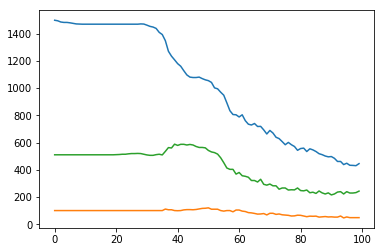

1


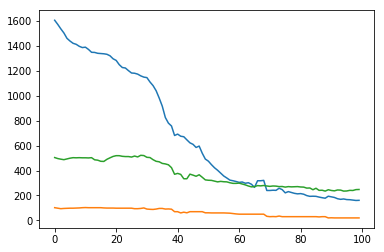

2


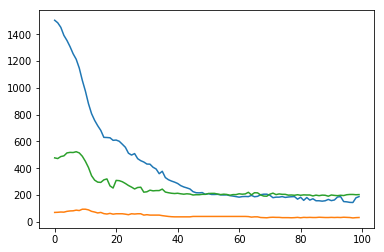

3


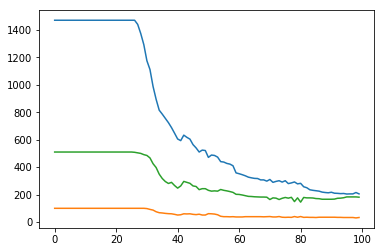

4


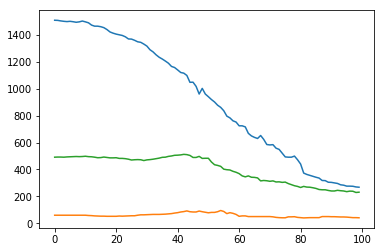

5


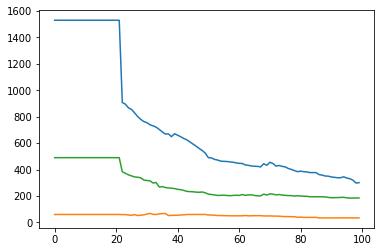

6


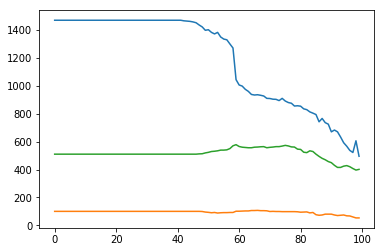

7


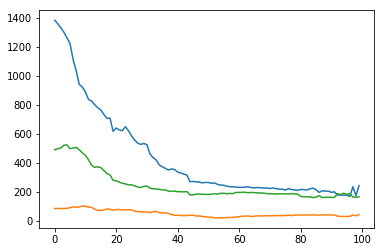

8


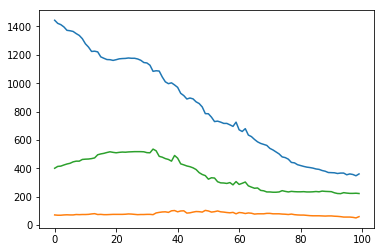

9


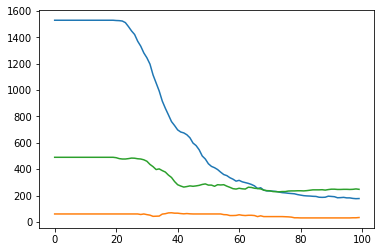

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


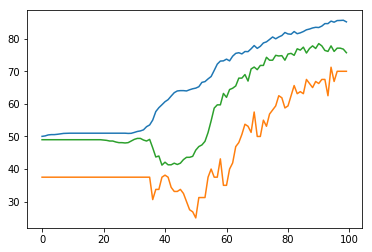

1


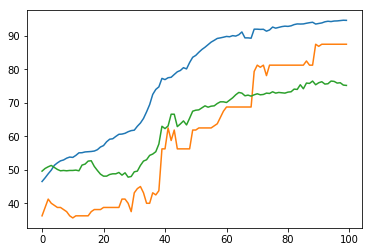

2


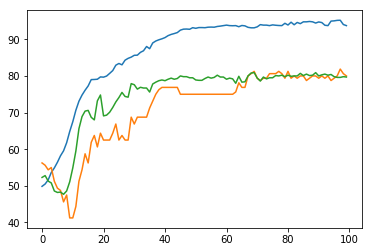

3


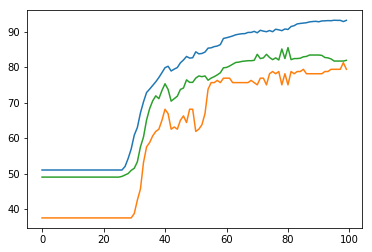

4


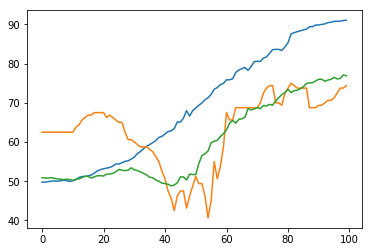

5


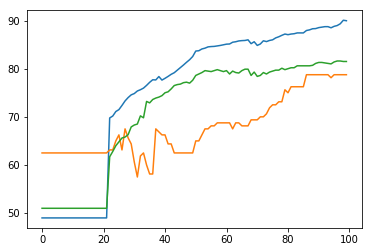

6


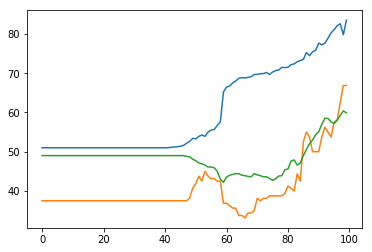

7


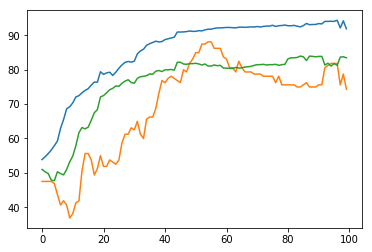

8


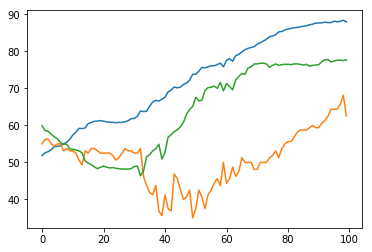

9


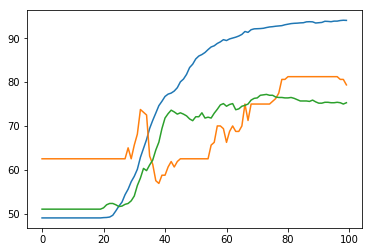

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(100,)
Training accuracy 90.5%+-3.662332057952881
Validation accuracy 75.3%+-6.9329938888549805
Testing accuracy 76.7%+-6.275355815887451


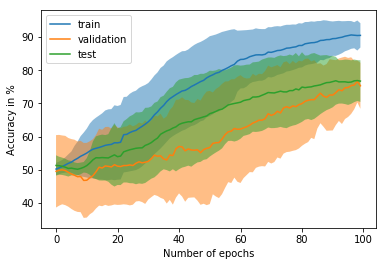

In [10]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(100))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))